In [2]:
import matplotlib.pyplot as plt
from skimage import io,data,draw,color,transform,feature
import cv2
import numpy as np
import math
from math import cos, sin, pi
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib inline 

# 霍夫变换检测椭圆

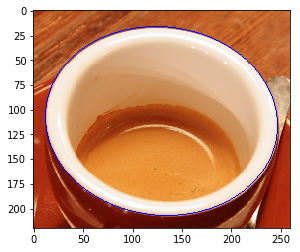

In [5]:
#读取图片
#image_rgb = io.imread('image.jpg')
image_rgb = data.coffee()[0:220, 160:420]
plt.imshow(image_rgb)
#转为灰度图
image_gray = color.rgb2gray(image_rgb)
plt.imshow(image_gray, cmap ='gray')#灰度图显示
#canny算子检测边缘
edges = feature.canny(image_gray, sigma=1.0, low_threshold=0.55, high_threshold=0.8)
plt.imshow(edges, cmap='gray')
#霍夫变换找到椭圆
result =transform.hough_ellipse(edges, accuracy=20, threshold=250, min_size=100, max_size=120)
result.sort(order='accumulator')
best=list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]] 
orientation = best[5]
cy, cx =draw.ellipse_perimeter(yc, xc, a, b, orientation) 
image_rgb[cy, cx] = (0, 0, 255)
plt.imshow(image_rgb)
plt.show()
#假设已经找到了目标图像椭圆点，以及在图片中的像素位置，然后估计圆中心三维坐标点
yc, xc, a, b = [int(round(x)) for x in best[1:5]] 
orientation = best[5]
cy, cx = draw.ellipse_perimeter(yc, xc, a, b, orientation)
Y = cy[1::50]
X = cx[1::50]

# 圆模型

输入：像平面圆心坐标(x, y)，圆半径像素长度(r)，像元尺寸du，相机焦距f，环半径R，照片尺寸(width, height)  
输出：圆心在相机坐标系下坐标(xc, yc, zc)  
${(x-\frac{width}{2})*du = \frac{x_{c}*f}{z_{c}}}$  
${(y-\frac{height}{2})*du = \frac{y_{c}*f}{z_{c}}}$  

${f^{'}=\frac{R}{r}}$  
${x_{c}=\frac{(x-\frac{width}{2})*du*z_{c}}{f}}$  
${y_{c}=\frac{(y-\frac{height}{2})*du*z_{c}}{f}}$

${x_{c}=(x-\frac{width}{2})*f^{'}}$  
${y_{c}=(y-\frac{height}{2})*f^{'}}$  
${z_{c}={\frac{x_{c}*f}{(x-\frac{width}{2})*du}}  
       ={\frac{(x-\frac{width}{2})*f^{'}*f}{(x-\frac{width}{2})*du}}
       ={\frac{f^{'}*f}{du}}  }$

In [6]:
#如果确认默认是一个圆形
#输入圆心（x,y),半径r（像素级别）
h, w = 220, 260
x = xc-h/2
y = yc-w/2
r = (a+b)/2
R = 0.05
du = 0.0001
f = 0.039
f_ = R/r
xc = x*f_
yc = y*f_
zc = f*f_/du
print(xc, yc, zc)

0.009433962264150943 -0.008490566037735849 0.18396226415094338


# 椭圆模型

${f^{'}=\frac{R}{r}}$   
${x_{c}=(x-\frac{width}{2})*f^{'}}$     
${y_{c}=(y-\frac{height}{2})*f^{'}}$  
${z_{c}={\frac{x_{c}*f}{(x-\frac{width}{2})*du}}  
       ={\frac{(x-\frac{width}{2})*f^{'}*f}{(x-\frac{width}{2})*du}}
       ={\frac{f^{'}*f}{du}}  }$

对于图像中检测到的椭圆(ex, ey, a, b, orientation)
- 平面约束  
（圆环确定的平面：${a*x+b*y+c*z=1}$）


In [7]:
from scipy.optimize import fsolve
import random

In [8]:
def ff(x):#传入初始值
    [a, b, c, x, y, z, f] = [float(i) for i in x]
    functions = []
    R = 20
    R_2 = R**2
    # for ii in random.sample(range(len(Y)), 7):
    for ii in select:
        px, py = X[ii], Y[ii]
        function = (x-px/(a*px+b*py+c*f))**2 + (y-py/(a*px+b*py+c*f))**2 + (z-1/(a*px/f+b*py/f+c))**2 - R_2
        functions.append(function)
    return functions

for i in range(10):
    select = random.sample(range(len(Y)), 7)
    result = fsolve(ff, [1]*7,maxfev=50000)
    print(result, ff(result))

[  2.80932781e+02   4.66332450e+02   1.18738707e+04   1.48254950e+01
   5.30273054e+00   1.23323727e+01  -1.00959496e+03] [0.00019682420406752499, -9.4650492769687844e-05, -0.00020407692386470444, -9.7091173643093498e-05, 0.00018493790037155122, -0.00029122941134573921, 0.00028929130235155753]


/home/cyb/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/cyb/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[    3.64061788     3.20534507  1287.88419097    12.18768234    12.98562662
     9.10234857   997.35869997] [-0.00069383066698947005, -0.00075263558710503276, -0.0027221868538163108, -0.001919529459826208, 0.00091695661717494659, 0.0029508847069337207, 0.0020443752109713387]
[  3.01103191e+01  -4.40078026e+00  -1.36009701e+03   1.97285417e+01
   3.28167569e+00  -1.37892497e-01  -1.27603393e+03] [0.00069250627967676337, 0.0027365894939634927, -0.0017257545525808382, -0.0024334043520184423, -0.00047222962029991322, 0.001810024666440313, -0.0001658875557382089]
[  13.86729948   14.28202335  263.77767832   -0.94725861   -0.90665338
   19.96225514  -62.60864473] [0.021633802693713733, -0.075410531805232495, 0.026835024944830366, 0.036406876908472441, 0.0046945575877543888, 0.03353983461710186, -0.054101513123782752]
[  7.40842165e+01   2.96021765e+02   1.37915920e+03   1.04926175e+00
   4.18299723e+00   1.95301934e+01  -1.32258201e+01] [-8.7463981856217288e-05, -0.001361232458464201, -0.001

In [9]:
from scipy.optimize import fmin

In [10]:
def myfunc(x):
    [a, b, c, x, y, z, f] = [float(i) for i in x]
    R = 2
    R_2 = R**2
    res = 0
    for ii in range(len(Y)):
        px, py = X[ii], Y[ii]
        function = (x-px/(a*px+b*py+c*f))**2 + (y-py/(a*px+b*py+c*f))**2 + (z-1/(a*px/f+b*py/f+c))**2 - R_2
        res += abs(function)
    return res
Y, X = cy, cx
# [1e-6, 1e-6, 1e-6, 1, 1, 1, 1000]
result = fmin(myfunc, [1]*7, xtol=1e-6, ftol=1e-6, maxiter=1e4)

Optimization terminated successfully.
         Current function value: 0.167598
         Iterations: 1237
         Function evaluations: 1958


In [11]:
myfunc(result)

0.16759793805749634

In [12]:
result

array([ 17.00566223,  14.25020603, -12.65887792,   1.34572464,
         1.13022442,  -1.03353734, -21.88002603])

In [13]:
result

array([ 17.00566223,  14.25020603, -12.65887792,   1.34572464,
         1.13022442,  -1.03353734, -21.88002603])

In [14]:
result

array([ 17.00566223,  14.25020603, -12.65887792,   1.34572464,
         1.13022442,  -1.03353734, -21.88002603])

# 测试

## 空间中的圆

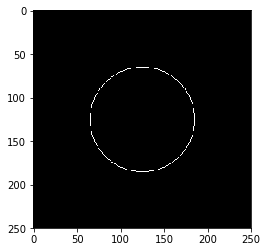

In [15]:
xc, yc = draw.circle_perimeter(125, 125, 60)
flat = np.zeros((250, 250, 3), dtype=np.uint8)
flat[xc, yc, :] = 255
plt.imshow(flat)
plt.show()

## 空间坐标

In [16]:
points = np.zeros((len(xc), 3))
points[:, 0] = xc
points[:, 1] = yc
points[:, 2] = 10

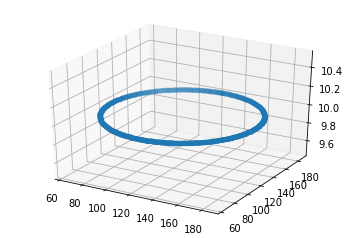

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2])
plt.show()

## 相机投影

In [3]:
#焦距为30mm，像元尺寸为12um
f = 30*1e-3
du = 12*1e-4

In [3]:
#对所有的空间中坐标点进行投影
#x = xc*f/zc
#y = yc*f/zc
def xyz_draw(points, name='1'):
    fig = plt.figure(name)
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    
def xyz_projection1(points, name='1'):
    x = -points[:,0]*f/points[:,2]
    y = -points[:,1]*f/points[:,2]
    z = np.zeros((len(x), 1)) - f
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    ax.scatter(x, y, z)
    for ii in range(0,len(x), 5):#画投影线
        ax.plot3D([points[ii, 0], x[ii]], [points[ii, 1], y[ii]], [points[ii, 2], z[ii]])
    
    #画焦平面
    plt.figure('jiao flat')
    plt.plot(-x, -y, '.r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    return -x, -y

def xyz_projection(points, name='1'):
    K = np.array([[f, 0, 0],
            [0, f, 0],
            [0, 0, 1]])
    #points_extent = np.hstack((points, np.ones((points.shape[0],1))))
    points_projection = np.dot(K, points.T)/points[:, 2].T
    #x = -points[:,0]*f/points[:,2]
    #y = -points[:,1]*f/points[:,2]
    x = points_projection[0,:]
    y = points_projection[1,:]
    z = np.zeros((len(x), 1)) + f
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    ax.scatter(x, y, z)
    for ii in range(0,len(x), 5):#画投影线
        ax.plot3D([points[ii, 0], x[ii]], [points[ii, 1], y[ii]], [points[ii, 2], z[ii]])
    
    #画焦平面
    plt.figure('jiao flat')
    plt.plot(x, y, '.r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    return x, y

## 环平面旋转后投影

旋转变换参考
https://www.cnblogs.com/graphics/archive/2012/08/10/2627458.html

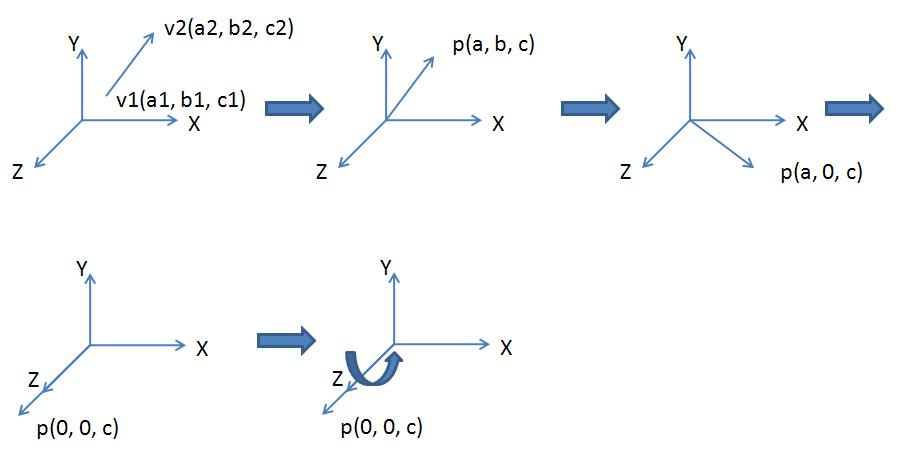

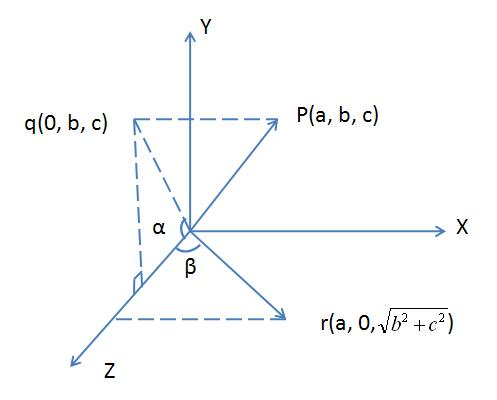

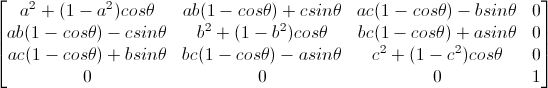

In [20]:
# 旋转轴v1v2：v1(a1, b1, c1), v2(a2, b2, c2)
# 旋转角度theta
# 位移矩阵
theta = 0
[a1, b1, c1] = [150, 150, 10]
[a2, b2, c2] = [150, 150, 11]
[a, b, c] = [0, 0, 10]
T1 = np.array([[1,0,0,-a1],
              [0,1,0,-b1],
              [0,0,1,-c1],
              [0,0,0,1]])
T2 = np.array([[1,0,0,a1],
              [0,1,0,b1],
              [0,0,1,c1],
              [0,0,0,1]])
R = np.array([[a**2+(1-a**2)*cos(theta), a*b*(1-cos(theta))+c*cos(theta), a*c*(1-cos(theta))-b*sin(theta), 0],
             [a*b*(1-cos(theta))-c*sin(theta), b**2+(1-b**2)*cos(theta), b*c*(1-cos(theta))+a*sin(theta), 0],
             [a*c*(1-cos(theta)+b*sin(theta)), b*c*(1-cos(theta))-a*sin(theta), c**2+(1-c**2)*cos(theta), 0],
             [0, 0, 0, 1]])

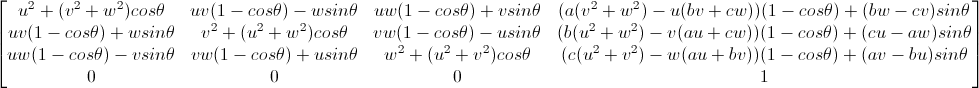

In [21]:
theta = pi/4
[u, v, w] = [1, 0, 0]#旋转轴
[a, b, c] = [0, 0, 0]#第一个点，位移向量
RR = np.array([[u**2+(v**2+w**2)*cos(theta), u*v*(1-cos(theta))-w*sin(theta), u*w*(1-cos(theta))+v*sin(theta), (a*(v**2+w**2)-u*(b*v+c*w))*(1-cos(theta))+(b*w-c*v)*sin(theta)],
               [u*v*(1-cos(theta))+w*sin(theta), v**2+(u**2+w**2)*cos(theta), v*w*(1-cos(theta))-u*sin(theta), (b*(u**2+w**2)-v*(a*u+c*w))*(1-cos(theta))+(c*u-a*w)*sin(theta)],
               [u*w*(1-cos(theta))-v*sin(theta), u*w*(1-cos(theta))+u*sin(theta), w**2+(u**2+v**2)*cos(theta), (c*(w**2+v**2)-w*(a*u+b*v))*(1-cos(theta))+(a*v-b*u)*sin(theta)],
               [0, 0, 0, 1]])

## 画出旋转后的平面

In [4]:
# 旋转轴v1v2：v1(a1, b1, c1), v2(a2, b2, c2)
# 旋转角度theta
# 位移矩阵
def xyz_rotation(p1, theta, name, r_axis=[1, 0, 0]):
    fig = plt.figure(name)
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    points_extent = np.hstack((points, np.ones((points.shape[0],1))))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #theta = -i/20*pi
    #[a1, b1, c1] = [125, 125, 10]
    #[a, b, c] = [1, 0, 0]
    #T1 = np.array([[1,0,0,-a1],
                  #[0,1,0,-b1],
                  #[0,0,1,-c1],
                  #[0,0,0,1]])
    #T2 = np.array([[1,0,0,a1],
                  #[0,1,0,b1],
                  #[0,0,1,c1],
                  #[0,0,0,1]])
    #R = np.array([[a**2+(1-a**2)*cos(theta), a*b*(1-cos(theta))+c*cos(theta), a*c*(1-cos(theta))-b*sin(theta), 0],
                 #[a*b*(1-cos(theta))-c*sin(theta), b**2+(1-b**2)*cos(theta), b*c*(1-cos(theta))+a*sin(theta), 0],
                 #[a*c*(1-cos(theta)+b*sin(theta)), b*c*(1-cos(theta))-a*sin(theta), c**2+(1-c**2)*cos(theta), 0],
                 #[0, 0, 0, 1]])
    if np.linalg.norm(np.array(r_axis), 2)==0:
        return -1
    else:
        #[u, v, w] = [1, 0, 0]#旋转轴，需要是单位向量
        [u, v, w] = np.array(r_axis)/np.linalg.norm(np.array(r_axis), 2)
    [a, b, c] = p1[:]
    #[a, b, c] = [125, 125, 10]#第一个点，位移向量
    #[a, b, c] = [0, 0, 0]
    #theta = pi/4
    RR = np.array([[u**2+(v**2+w**2)*cos(theta), u*v*(1-cos(theta))-w*sin(theta), u*w*(1-cos(theta))+v*sin(theta), (a*(v**2+w**2)-u*(b*v+c*w))*(1-cos(theta))+(b*w-c*v)*sin(theta)],
                   [u*v*(1-cos(theta))+w*sin(theta), v**2+(u**2+w**2)*cos(theta), v*w*(1-cos(theta))-u*sin(theta), (b*(u**2+w**2)-v*(a*u+c*w))*(1-cos(theta))+(c*u-a*w)*sin(theta)],
                   [u*w*(1-cos(theta))-v*sin(theta), u*w*(1-cos(theta))+u*sin(theta), w**2+(u**2+v**2)*cos(theta), (c*(w**2+v**2)-w*(a*u+b*v))*(1-cos(theta))+(a*v-b*u)*sin(theta)],
                   [0, 0, 0, 1]])

    #print(name)
    #print(RR)
    points_extent_draw = points_extent.dot(RR.T)
    #points_extent_draw1 = points_extent.dot(T1.dot(R).dot(T2))
    ax.scatter(points_extent_draw[:,0], points_extent_draw[:,1], points_extent_draw[:,2])
    #ax.scatter(points_extent_draw1[:,0], points_extent_draw1[:,1], points_extent_draw1[:,2], 'b')
    ax.plot3D([a, a+u*100], [b, b+v*100], [c, c+w*100], 'r')
    return points_extent_draw

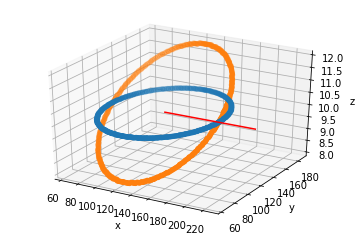

In [23]:
points_extent_draw = xyz_rotation([125, 125, 10], pi/100, '100')
plt.show()

## 平面旋转以及投影

(array([ 0.555,  0.195,  0.555,  0.195,  0.375,  0.375,  0.375,  0.375,
         0.555,  0.195,  0.555,  0.195,  0.378,  0.372,  0.378,  0.372,
         0.555,  0.195,  0.555,  0.195,  0.381,  0.369,  0.381,  0.369,
         0.555,  0.195,  0.555,  0.195,  0.384,  0.366,  0.384,  0.366,
         0.555,  0.195,  0.555,  0.195,  0.387,  0.363,  0.387,  0.363,
         0.555,  0.195,  0.555,  0.195,  0.39 ,  0.36 ,  0.39 ,  0.36 ,
         0.555,  0.195,  0.555,  0.195,  0.393,  0.357,  0.393,  0.357,
         0.555,  0.195,  0.555,  0.195,  0.396,  0.354,  0.396,  0.354,
         0.552,  0.198,  0.552,  0.198,  0.399,  0.351,  0.399,  0.351,
         0.552,  0.198,  0.552,  0.198,  0.402,  0.348,  0.402,  0.348,
         0.552,  0.198,  0.552,  0.198,  0.405,  0.345,  0.405,  0.345,
         0.552,  0.198,  0.552,  0.198,  0.408,  0.342,  0.408,  0.342,
         0.552,  0.198,  0.552,  0.198,  0.411,  0.339,  0.411,  0.339,
         0.552,  0.198,  0.552,  0.198,  0.414,  0.336,  0.414, 

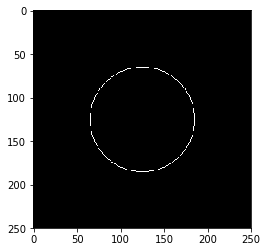

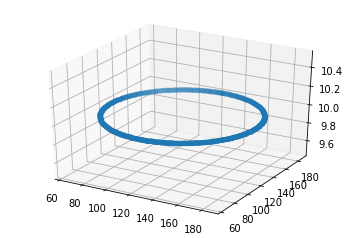

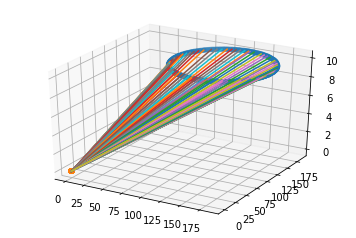

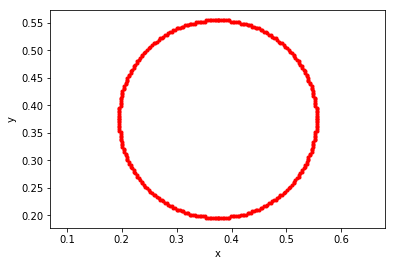

In [24]:
#空间中的圆
xc, yc = draw.circle_perimeter(125, 125, 60)
flat = np.zeros((250, 250, 3), dtype=np.uint8)
plt.figure('flat')
flat[xc, yc, :] = 255
plt.imshow(flat)
points = np.zeros((len(xc), 3))
points[:, 0] = xc
points[:, 1] = yc
points[:, 2] = 10
xyz_draw(points, 'circle1')
xyz_projection(points, 'circle1')

(array([ 0.55527399,  0.19509627,  0.55527399,  0.19509627,  0.31566424,
         0.31566424,  0.46236816,  0.46236816,  0.55353444,  0.19448507,
         0.55702451,  0.19571132,  0.31818955,  0.31313893,  0.46606711,
         0.45866921,  0.55180576,  0.1938777 ,  0.55878611,  0.19633025,
         0.32071487,  0.31061361,  0.46976605,  0.45497027,  0.55008783,
         0.1932741 ,  0.56055888,  0.19695312,  0.32324018,  0.3080883 ,
         0.473465  ,  0.45127132,  0.54838057,  0.19267426,  0.56234293,
         0.19757995,  0.3257655 ,  0.30556299,  0.47716394,  0.44757238,
         0.54668388,  0.19207812,  0.56413838,  0.19821078,  0.32829081,
         0.30303767,  0.48086289,  0.44387343,  0.54499765,  0.19148566,
         0.56594532,  0.19884565,  0.33081612,  0.30051236,  0.48456183,
         0.44017449,  0.54332179,  0.19089685,  0.56776388,  0.19948461,
         0.33334144,  0.29798704,  0.48826078,  0.43647554,  0.53872834,
         0.19323951,  0.56651528,  0.20320657,  0.3

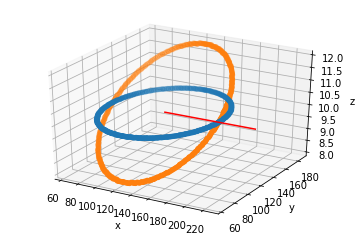

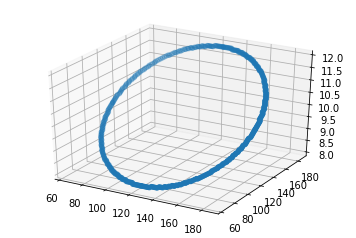

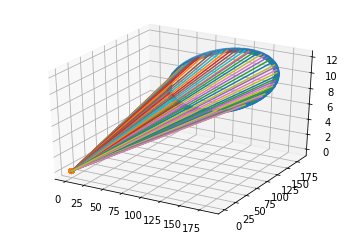

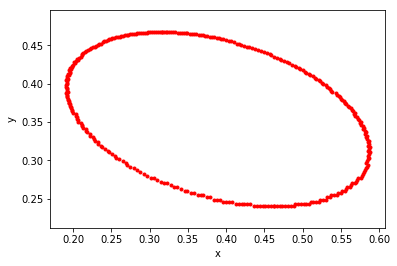

In [25]:
points_extent_draw = xyz_rotation([125, 125, 10], pi/100, '100')
xyz_draw(points_extent_draw, 'circle1')
xyz_projection(points_extent_draw, 'circle1')

# 如何从平面投影得到circle三维坐标

## 焦平面到成像

In [5]:
# ccd宽度
def xyz_get_photo(x, y, du):#从空间中的点到平面成像
    #上下左右添加20个像素
    xmax = x.max()+20*du
    xmin = x.min()-20*du
    ymax = y.max()+20*du
    ymin = y.min()-20*du
    width, height = (xmax-xmin)//du, (ymax-ymin)//du
    #print(width, height)
    flat = np.zeros((int(height), int(width), 3), dtype=np.uint8)
    plt.figure('flat')
    flat[[int(i) for i in (y-ymin)//du], [int(i) for i in (x-xmin)//du], :] = 255
    plt.imshow(flat)
    return flat

def xyz_get_photo1(x, y, du):#从空间中的点到平面成像
    #上下左右添加20个像素
    xmax = x.max()+20*du
    xmin = x.min()-20*du
    ymax = y.max()+20*du
    ymin = y.min()-20*du
    width, height = (xmax-xmin)//du, (ymax-ymin)//du
    #print(width, height)
    flat = np.zeros((int(width), int(height), 3), dtype=np.uint8)
    plt.figure('flat')
    flat[[int(i) for i in (x-xmin)//du], [int(i) for i in (y-ymin)//du], :] = 255
    plt.imshow(flat)
    return flat

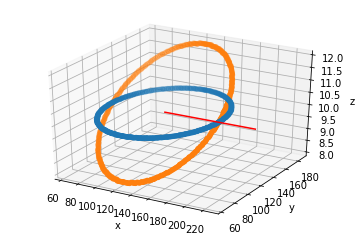

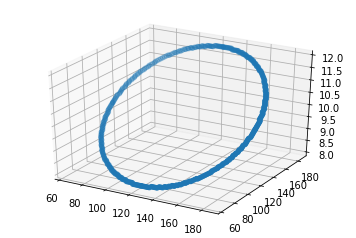

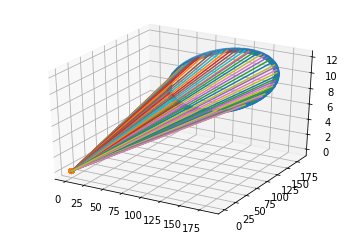

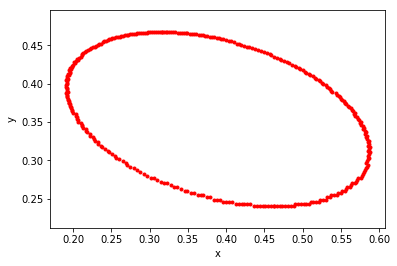

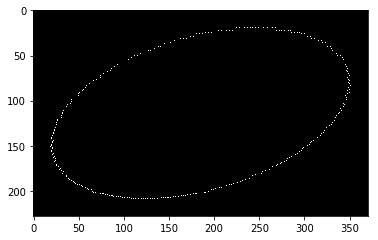

In [27]:
#空间中的圆
du = 12e-4#像元尺寸
xc, yc = draw.circle_perimeter(125, 125, 60)
points = np.zeros((len(xc), 3))
points[:, 0] = xc
points[:, 1] = yc
points[:, 2] = 10
#将空间的点绕轴旋转
points_extent_draw = xyz_rotation([125, 125, 10], pi/100, '100')
xyz_draw(points_extent_draw, 'circle1')
#焦平面成像
x, y = xyz_projection(points_extent_draw, 'circle1')
#焦平面到像平面
flat = xyz_get_photo(x, y, du)

## 使用霍夫变换检测椭圆

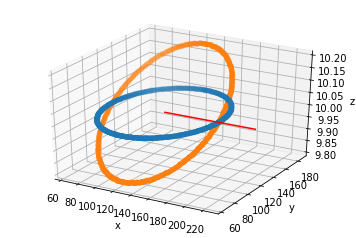

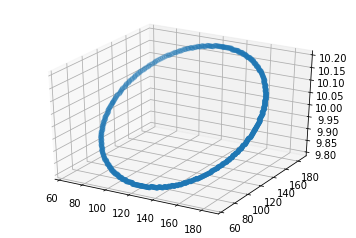

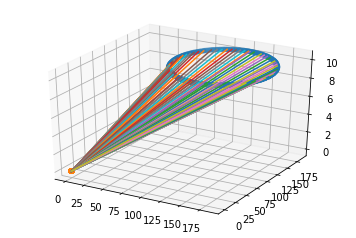

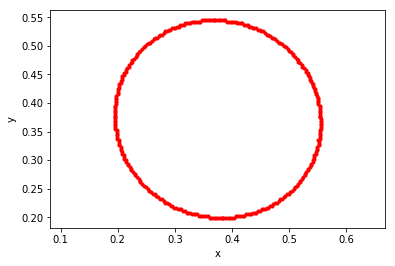

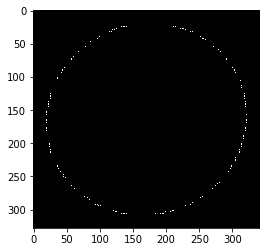

In [28]:
#发现有问题，怎么变化参数都检测不准
points_extent_draw = xyz_rotation([125, 125, 10], pi/1000, '100')
xyz_draw(points_extent_draw, 'circle1')
x, y = xyz_projection(points_extent_draw, 'circle1')
flat = xyz_get_photo(x, y, du)

[]


IndexError: index -1 is out of bounds for axis 0 with size 0

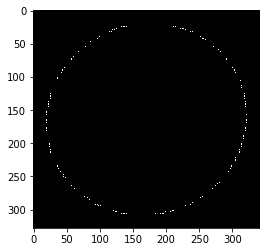

In [29]:
#转为灰度图
image_rgb = flat
image_gray = color.rgb2gray(image_rgb)
plt.imshow(image_gray, cmap ='gray')#灰度图显示
#canny算子检测边缘
#edges = feature.canny(image_gray)
#plt.imshow(edges, cmap='gray')
#霍夫变换找到椭圆
result =transform.hough_ellipse(image_gray, threshold=250)
result.sort(order='accumulator')
print(result)
best=list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]] 
orientation = best[5]
cy, cx =draw.ellipse_perimeter(yc, xc, a, b, orientation) 
image_rgb[cy, cx] = (0, 0, 255)
plt.imshow(image_rgb)
plt.show()
#假设已经找到了目标图像椭圆点，以及在图片中的像素位置，然后估计圆中心三维坐标点
yc, xc, a, b = [int(round(x)) for x in best[1:5]] 
orientation = best[5]
cy, cx = draw.ellipse_perimeter(yc, xc, a, b, orientation)

## 从焦平面坐标拟合椭圆

### 获得焦平面投影点坐标x,y

In [91]:
points_extent_draw[1:3]

array([[  65.       ,  125.       ,    9.9950656,    1.       ],
       [ 185.       ,  125.       ,    9.9950656,    1.       ]])

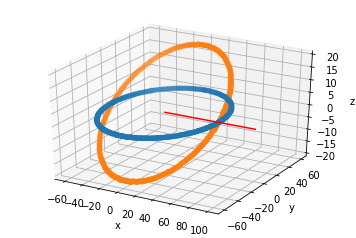

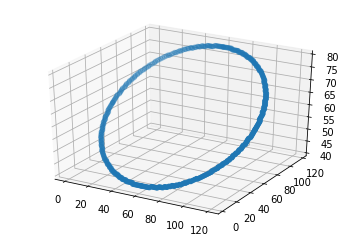

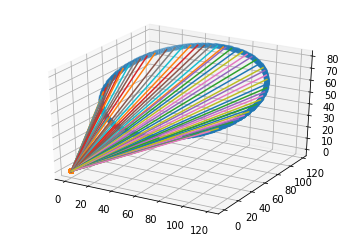

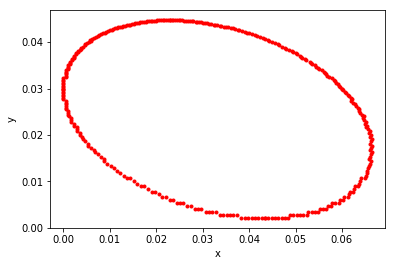

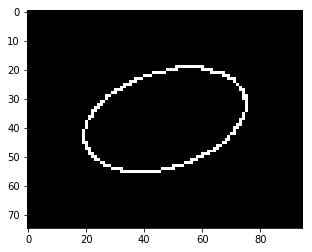

In [127]:
#直接从物方点->焦平面成像点，使用焦平面点进行椭圆拟合
#空间中的圆
f = 30*1e-3
du = 12e-4#像元尺寸
#在z=10的空间平面上画圆，获得以(125,125)为圆心坐标，60为半径的圆
r = 60
xc, yc = draw.circle_perimeter(125, 125, r)
#xc, yc = draw.circle(125, 125, 60)#填满
#获得物方点points
points = np.zeros((len(xc), 3))
points[:, 0] = xc-125
points[:, 1] = yc-125
points[:, 2] = 0
#将空间的点绕轴旋转
#points_extent_draw = xyz_rotation([125, 125, 10], pi/100, '100')
points_extent_draw = xyz_rotation([0, 0, 0], pi/10, '100')
#发现好像都是绕着给定的旋转方向旋转的，而没有旋转轴
points_extent_draw[:, 2] += 60
points_extent_draw[:, 1] += 60
points_extent_draw[:, 0] += 60
xyz_draw(points_extent_draw, 'circle1')
#焦平面成像
x, y = xyz_projection(points_extent_draw[:, 0:3], 'circle1')
#焦平面到像平面
flat = xyz_get_photo(x, y, du)

### 拟合椭圆

In [131]:
#points类型要求是numpy.array（[[[x,y]],[[x1,y1]]...]） 并不是把所有点都包括在椭圆里面，而是拟合出一个椭圆尽量使得点都在圆上
#points类型需要是int32的
points_focalFlat = np.zeros((len(x), 1, 2), dtype=int)
#将所有的点放大1000倍，然后除以1000倍
points_focalFlat[:,0, 0] = [int(i*10000) for i in x]
points_focalFlat[:,0, 1] = [int(i*10000) for i in y]

In [132]:
#找到图像中的椭圆
ellipse = cv2.fitEllipse(points_focalFlat)

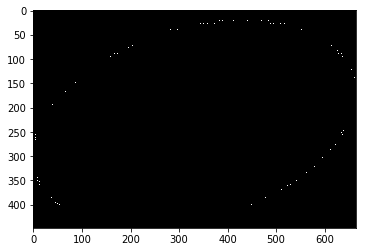

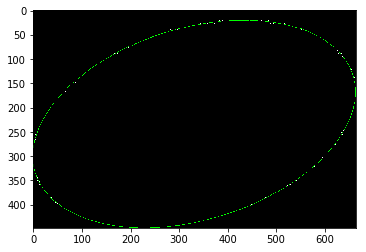

In [134]:
img = np.zeros((int(y.max()*10000)+1, int(x.max()*10000)+1, 3), dtype=np.uint8)
img[[int(i*10000) for i in y], [int(i*10000) for i in x], :] = 255
plt.imshow(img)
plt.show()
img = cv2.ellipse(img, (ellipse[0], ellipse[1], ellipse[2]) , (0,255,0), 1)
plt.imshow(img)
plt.show()

### 还原在焦平面尺寸

In [135]:
#ellipse的焦平面坐标默认乘上10000倍
#中心
center = [ellipse[0][0]/10000, ellipse[0][1]/10000]
#长短轴的二倍
axes = [ellipse[1][0]/10000, ellipse[1][1]/10000]
#旋转角度（顺时针）
angle = ellipse[2]

### 获得椭圆参数在焦平面上的投影三点

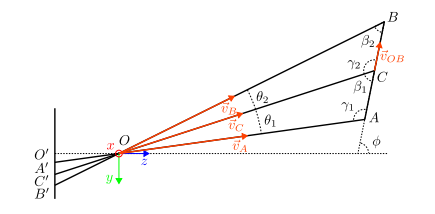

In [136]:
# 在zy平面上的投影线，按照方程直接求得最大值和最小值（没有找到推导公式）
# 直接按照画椭圆，然后得到横纵坐标极值坐标点
x, y = draw.ellipse_perimeter(int(center[0]*10000), int(center[1]*10000), int(axes[0]/2*10000), int(axes[1]/2*10000), orientation=-angle/180*pi)

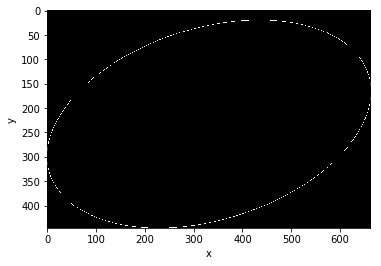

In [163]:
img = np.zeros((y.max()+1, x.max()+1, 3), dtype=np.uint8)
img[y, x, :] = 255
plt.imshow(img)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [138]:
# 获得三个点zy平面上投影,只需要管焦平面上的点
max_x_index = list(x).index(x.max())
max_y_index = list(y).index(y.max())
min_x_index = list(x).index(x.min())
min_y_index = list(y).index(y.min())
# 获得四个点
Azy_x = x[min_x_index]/10000
Azy_y = y[min_x_index]/10000
Bzy_x = x[max_x_index]/10000
Bzy_y = y[max_x_index]/10000

Axy_x = x[min_y_index]/10000
Axy_y = y[min_y_index]/10000
Bxy_x = x[max_y_index]/10000
Bxy_y = y[max_y_index]/10000

C_x = center[0]
C_y = center[1]

#### 计算

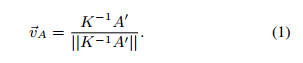

In [139]:
K = np.array([[f, 0, 0],
             [0, f, 0],
             [0, 0, 1]])

In [154]:
#np.linalg.inv(K)
#未将单位向量在zy平面上投影
va_zy = np.dot(np.linalg.inv(K), np.array([Azy_x, Azy_y, 1]))
va_zy = va_zy/np.linalg.norm(va_zy, 2)
vb_zy = np.dot(np.linalg.inv(K), np.array([Bxy_x, Bxy_y, 1]))
vb_zy = vb_zy/np.linalg.norm(vb_zy, 2)
vc_zy = np.dot(np.linalg.inv(K), np.array([C_x, C_y, 1]))
vc_zy = vc_zy/np.linalg.norm(vc_zy, 2)
print(va_zy)
print(vb_zy)
print(vc_zy)

[ 0.          0.69253183  0.72138732]
[ 0.3910116   0.7631586   0.51448895]
[ 0.65692143  0.4631618   0.59492469]


In [147]:
#np.linalg.inv(K)
#在往zy平面上投影的时候，单位向量也需要往zy平面上投影
va_zy = np.dot(np.linalg.inv(K), np.array([Azy_x, Azy_y, 1]))
va_zy = np.array([va_zy[1], va_zy[2]])
va_zy = va_zy/np.linalg.norm(va_zy, 2)
vb_zy = np.dot(np.linalg.inv(K), np.array([Bxy_x, Bxy_y, 1]))
vb_zy = np.array([vb_zy[1], vb_zy[2]])
vb_zy = vb_zy/np.linalg.norm(vb_zy, 2)
vc_zy = np.dot(np.linalg.inv(K), np.array([C_x, C_y, 1]))
vc_zy = np.array([vc_zy[1], vc_zy[2]])
vc_zy = vc_zy/np.linalg.norm(vc_zy, 2)
print(va_zy)
print(vb_zy)
print(vc_zy)

[ 0.69253183  0.72138732]
[ 0.82917255  0.55899273]
[ 0.61430631  0.78906765]


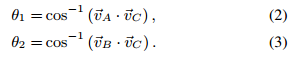

In [155]:
theta1_zy = math.acos(np.dot(va_zy, vc_zy))
theta2_zy = math.acos(np.dot(vb_zy, vc_zy))
print(theta1_zy/pi*180, theta2_zy/pi*180)

41.416082566052744 23.592949835412867


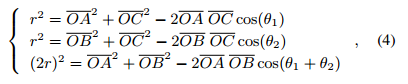

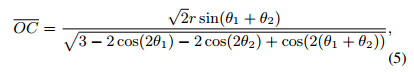

In [156]:
oc_length_zy = math.sqrt(2)*r*sin(theta1_zy+theta2_zy)/math.sqrt(3-2*cos(2*theta1_zy)-2*cos(2*theta2_zy)+cos(2*(theta1_zy+theta2_zy)))
print(r, oc_length_zy)

60 88.91445564609344


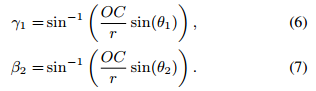

In [74]:
gama1_zy1 = math.asin(oc_length_zy/r*sin(theta1_zy))
gama1_zy2 = pi - gama1_zy1
beta2_zy1 = math.asin(oc_length_zy/r*sin(theta2_zy))
beta2_zy2 = pi - beta2_zy1
print(gama1_zy1*180/pi, gama1_zy2*180/pi, beta2_zy1*180/pi, beta2_zy2*180/pi)

73.49943136559621 106.50056863440379 38.179761745655064 141.82023825434496


In [76]:
#找到满足条件的gama1_zy, 和beta2_zy
gama2_zy1 = theta1_zy + gama1_zy1
gama2_zy2 = theta1_zy + gama1_zy2
if np.abs((theta2_zy + gama2_zy1 + beta2_zy1) - pi)<1e-3:
    gama1_zy = gama1_zy1
    beta2_zy = beta2_zy1
    print('1', gama1_zy, beta2_zy)
if np.abs((theta2_zy + gama2_zy2 + beta2_zy1) - pi)<1e-3:
    gama1_zy = gama1_zy2
    beta2_zy = beta2_zy1
    print('2', gama1_zy, beta2_zy)
if np.abs((theta2_zy + gama2_zy1 + beta2_zy2) - pi)<1e-3:
    gama1_zy = gama1_zy1
    beta2_zy = beta2_zy2
    print('3', gama1_zy, beta2_zy)
if np.abs((theta2_zy + gama2_zy2 + beta2_zy2) - pi)<1e-3:
    gama1_zy = gama1_zy2
    beta2_zy = beta2_zy2
    print('4', gama1_zy, beta2_zy)

2 1.8587855779165472 0.6663625500886586


In [157]:
gama1_zy1 = math.asin(oc_length_zy/r*sin(theta1_zy))
gama1_zy2 = pi - gama1_zy1
beta2_zy1 = math.asin(oc_length_zy/r*sin(theta2_zy))
beta2_zy2 = pi - beta2_zy1
print(gama1_zy1*180/pi, gama1_zy2*180/pi, beta2_zy1*180/pi, beta2_zy2*180/pi)

78.61272666101866 101.38727333898133 36.378240937515734 143.62175906248427


In [158]:
#找到满足条件的gama1_zy, 和beta2_zy
#只有一种可能满足(8)式子
gama2_zy1 = theta1_zy + gama1_zy1
gama2_zy2 = theta1_zy + gama1_zy2
if np.abs((theta2_zy + gama2_zy1 + beta2_zy1) - pi)<1e-3:
    gama1_zy = gama1_zy1
    beta2_zy = beta2_zy1
    print('1', gama1_zy*180/pi, beta2_zy*180/pi)
if np.abs((theta2_zy + gama2_zy2 + beta2_zy1) - pi)<1e-3:
    gama1_zy = gama1_zy2
    beta2_zy = beta2_zy1
    print('2', gama1_zy*180/pi, beta2_zy*180/pi)
if np.abs((theta2_zy + gama2_zy1 + beta2_zy2) - pi)<1e-3:
    gama1_zy = gama1_zy1
    beta2_zy = beta2_zy2
    print('3', gama1_zy*180/pi, beta2_zy*180/pi)
if np.abs((theta2_zy + gama2_zy2 + beta2_zy2) - pi)<1e-3:
    gama1_zy = gama1_zy2
    beta2_zy = beta2_zy2
    print('4', gama1_zy*180/pi, beta2_zy*180/pi)

1 78.61272666101866 36.378240937515734


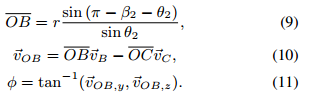

In [160]:
ob_length_zy = r*sin(pi-beta2_zy-theta2_zy)/sin(theta2_zy)
print(ob_length_zy)
vob_zy = ob_length_zy*vb_zy - oc_length_zy*vc_zy
print(vob_zy)
phi_zy = math.atan(vob_zy[1]/vob_zy[2])
print(phi_zy*180/pi)

129.78941881760431
[ -7.66064306  57.8681325   13.87781641]
76.51413020251643


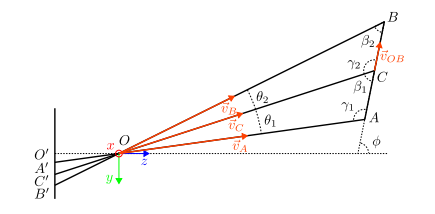

In [162]:
#知道oc的长度，倾斜角度为phi
#计算c在zy平面的坐标
60*math.sqrt(2)

84.8528137423857

# 测试

极值点：
azy 362.815342571 10.799502152
axy 6.5481903181 228.97967435
bzy 470.515712117 513.116208297
bxy 826.782864369 294.936036099
三个向量：
[ 0.77046384  0.0229335   0.63707105]
[ 0.62067411  0.67686995  0.39574073]
[ 0.72288096  0.45447568  0.52047572]
两个theta角度：
25.978775378219815 15.789502154340376
圆半径，oc投影长度
60 134.63708180562182
gama1,beta2分别可能的2个解：
79.40030988250183 100.59969011749818 37.632032349941724 142.3679676500583
gama1,beta2解：
2 100.59969011749818 37.632032349941724
cb投影长度：
177.07384161541782
cb向量：
[  1.25785652e+01   5.86666830e+01   5.68434189e-14]
倾斜角度phi：
89.99999999999994


<IPython.core.display.Javascript object>


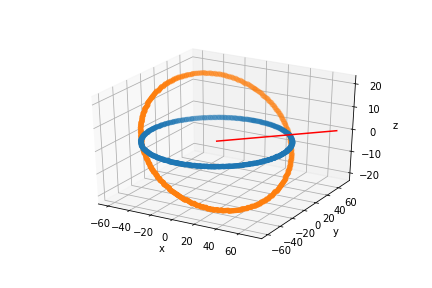

<IPython.core.display.Javascript object>


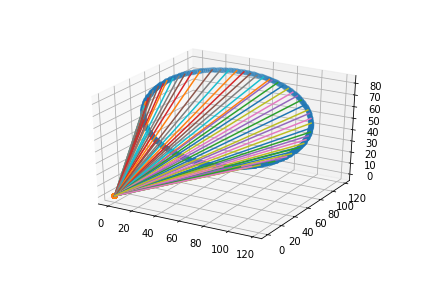

<IPython.core.display.Javascript object>


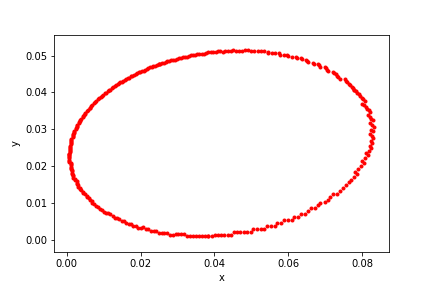

<IPython.core.display.Javascript object>


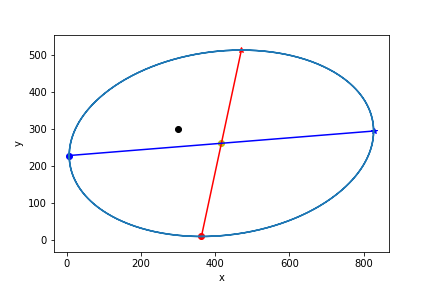

<IPython.core.display.Javascript object>


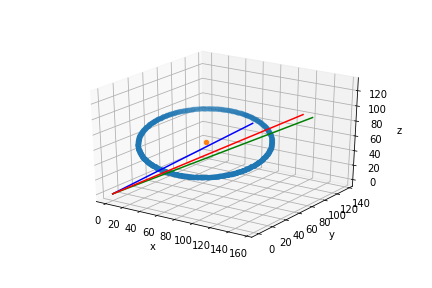

In [6]:
# plt.switch_backend('Qt5Agg')
plt.switch_backend('nbAgg')
#直接从物方点->焦平面成像点，使用焦平面点进行椭圆拟合
#空间中的圆
f = 30*1e-3
du = 12e-4#像元尺寸
#在z=10的空间平面上画圆，获得以(125,125)为圆心坐标，60为半径的圆
r = 60
xc, yc = draw.circle_perimeter(125, 125, r)
#xc, yc = draw.circle(125, 125, 60)#填满
#获得物方点points
points = np.zeros((len(xc), 3))
points[:, 0] = xc-125
points[:, 1] = yc-125
points[:, 2] = 0
#将空间的点绕轴旋转
#points_extent_draw = xyz_rotation([125, 125, 10], pi/100, '100')
points_extent_draw = xyz_rotation([0, 0, 0], 20/180*pi, '100', r_axis=[1, 1, 0])
#发现好像都是绕着给定的旋转方向旋转的，而没有旋转轴
points_extent_draw[:, 2] += 60
points_extent_draw[:, 1] += 60
points_extent_draw[:, 0] += 60
#xyz_draw(points_extent_draw, 'circle1')
#焦平面成像
x, y = xyz_projection(points_extent_draw[:, 0:3], 'circle1')
#焦平面到像平面
#flat = xyz_get_photo(x, y, du)

#points类型要求是numpy.array（[[[x,y]],[[x1,y1]]...]） 并不是把所有点都包括在椭圆里面，而是拟合出一个椭圆尽量使得点都在圆上
#points类型需要是int32的
points_focalFlat = np.zeros((len(x), 1, 2), dtype=int)
#将所有的点放大10000倍，然后除以10000倍
points_focalFlat[:,0, 0] = [int(i*10000) for i in x]
points_focalFlat[:,0, 1] = [int(i*10000) for i in y]

#找到图像中的椭圆
ellipse = cv2.fitEllipse(points_focalFlat)

img = np.zeros((int(y.max()*10000)+1, int(x.max()*10000)+1, 3), dtype=np.uint8)
img[[int(i*10000) for i in y], [int(i*10000) for i in x], :] = 255
#plt.imshow(img)
#plt.show()
#img = cv2.ellipse(img, (ellipse[0], ellipse[1], ellipse[2]) , (0,255,0), 1)
#plt.imshow(img)
#plt.show()

#ellipse的焦平面坐标默认乘上10000倍
#中心
center = [ellipse[0][0]/10000, ellipse[0][1]/10000]
#长短轴的二倍
axes = [ellipse[1][0]/10000, ellipse[1][1]/10000]
#旋转角度（顺时针）
angle = ellipse[2]

# 在zy平面上的投影线，按照方程直接求得最大值和最小值（没有找到推导公式）
# 直接按照画椭圆，然后得到横纵坐标极值坐标点
# x, y = draw.ellipse_perimeter(int(center[0]*10000), int(center[1]*10000), int(axes[0]/2*10000), int(axes[1]/2*10000), orientation=-angle/180*pi)
# xy里面有小于0的点，实际上不应该存在？
# 获得三个点zy平面上投影,只需要管焦平面上的点
# max_x_index = list(x).index(x.max())
# max_y_index = list(y).index(y.max())
# min_x_index = list(x).index(x.min())
# min_y_index = list(y).index(y.min())
# 获得四个点
# Azy_x = x[min_x_index]/10000
# Azy_y = y[min_x_index]/10000
# Bzy_x = x[max_x_index]/10000
# Bzy_y = y[max_x_index]/10000
# 
# Axy_x = x[min_y_index]/10000
# Axy_y = y[min_y_index]/10000
# Bxy_x = x[max_y_index]/10000
# Bxy_y = y[max_y_index]/10000
# img = np.zeros((y.max()+1, x.max()+1, 3), dtype=np.uint8)
# img[y, x, :] = 255
# img[y[min_x_index], x[min_x_index], :] = (255, 0, 0)
# img[y[max_x_index], x[max_x_index], :] = (255, 0, 0)
# img[y[min_y_index], x[min_y_index], :] = (255, 0, 0)
# img[y[max_y_index], x[max_y_index], :] = (255, 0, 0)
# print('四个点：')
# print(x[min_x_index], y[min_x_index], x[max_x_index], y[max_x_index], x[min_y_index], y[min_y_index], x[max_y_index], y[max_y_index])
# print(ellipse[0])
# plt.imshow(img)
# plt.xlabel('x')
# plt.ylabel('y')

# 直接使用公式计算最大值和最小值
phi = angle*pi/180
a = axes[0]*10000/2
b = axes[1]*10000/2
xe = center[0]*10000
ye = center[1]*10000
def fx(theta):
    return a*cos(phi)*np.cos(theta) - b*sin(phi)*np.sin(theta) + xe
def fy(theta):
    return a*sin(phi)*np.cos(theta) + b*cos(phi)*np.sin(theta) + ye
if phi==0:
    theta_x = 0
    theta_y = pi/2
else:
    theta_x = math.atan(-b*sin(phi)/(a*cos(phi)))
    theta_y = math.atan( b*cos(phi)/(a*sin(phi)))
if fx(theta_x)<fx(theta_x+pi):
    Axy_x = fx(theta_x)
    Axy_y = fy(theta_x)
    Bxy_x = fx(theta_x+pi)
    Bxy_y = fy(theta_x+pi)
else:
    Axy_x = fx(theta_x+pi)
    Axy_y = fy(theta_x+pi)
    Bxy_x = fx(theta_x)
    Bxy_y = fy(theta_x)
    
if fy(theta_y)<fy(theta_y+pi):
    Azy_x = fx(theta_y)
    Azy_y = fy(theta_y)
    Bzy_x = fx(theta_y+pi)
    Bzy_y = fy(theta_y+pi)
else:
    Azy_x = fx(theta_y+pi)
    Azy_y = fy(theta_y+pi)
    Bzy_x = fx(theta_y)
    Bzy_y = fy(theta_y)
print('极值点：')
print('azy', Azy_x, Azy_y)
print('axy', Axy_x, Axy_y)
print('bzy', Bzy_x, Bzy_y)
print('bxy', Bxy_x, Bxy_y)
theta = np.linspace(-2*pi,2*pi,num=1000)
plt.figure('ellipse')
plt.plot(Azy_x, Azy_y, 'ro')
plt.plot(Axy_x, Axy_y, 'bo')
plt.plot(Bzy_x, Bzy_y, 'r*')
plt.plot(Bxy_x, Bxy_y, 'b*')
plt.plot(center[0]*10000, center[1]*10000, 'yo')
plt.plot(300, 300, 'ko')
plt.plot([Azy_x, Bzy_x], [Azy_y, Bzy_y], 'r')
plt.plot([Axy_x, Bxy_x], [Axy_y, Bxy_y], 'b')
plt.plot(fx(theta), fy(theta))
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')

Azy_x = Azy_x/10000
Azy_y = Azy_y/10000
Bzy_x = Bzy_x/10000
Bzy_y = Bzy_y/10000
Axy_x = Axy_x/10000
Axy_y = Axy_y/10000
Bxy_x = Bxy_x/10000
Bxy_y = Bxy_y/10000

C_x = center[0]
C_y = center[1]

K = np.array([[f, 0, 0],
             [0, f, 0],
             [0, 0, 1]])

#np.linalg.inv(K)
#在往zy平面上投影的时候，单位向量也需要往zy平面上投影
va_zy = np.dot(np.linalg.inv(K), np.array([Azy_x, Azy_y, 1]))
#va_zy = np.array([va_zy[1], va_zy[2]])
va_zy = va_zy/np.linalg.norm(va_zy, 2)
vb_zy = np.dot(np.linalg.inv(K), np.array([Bzy_x, Bzy_y, 1]))
#vb_zy = np.array([vb_zy[1], vb_zy[2]])
vb_zy = vb_zy/np.linalg.norm(vb_zy, 2)
vc_zy = np.dot(np.linalg.inv(K), np.array([C_x, C_y, 1]))
#vc_zy = np.array([vc_zy[1], vc_zy[2]])
vc_zy = vc_zy/np.linalg.norm(vc_zy, 2)
print('三个向量：')
print(va_zy)
print(vb_zy)
print(vc_zy)

theta1_zy = math.acos(np.dot(va_zy, vc_zy))
theta2_zy = math.acos(np.dot(vb_zy, vc_zy))
print('两个theta角度：')
print(theta1_zy/pi*180, theta2_zy/pi*180)

oc_length_zy = math.sqrt(2)*r*sin(theta1_zy+theta2_zy)/math.sqrt(3-2*cos(2*theta1_zy)-2*cos(2*theta2_zy)+cos(2*(theta1_zy+theta2_zy)))
print('圆半径，oc投影长度')
print(r, oc_length_zy)

gama1_zy1 = math.asin(oc_length_zy/r*sin(theta1_zy))
gama1_zy2 = pi - gama1_zy1
beta2_zy1 = math.asin(oc_length_zy/r*sin(theta2_zy))
beta2_zy2 = pi - beta2_zy1
print('gama1,beta2分别可能的2个解：')
print(gama1_zy1*180/pi, gama1_zy2*180/pi, beta2_zy1*180/pi, beta2_zy2*180/pi)

#找到满足条件的gama1_zy, 和beta2_zy
#只有一种可能满足(8)式子
gama2_zy1 = theta1_zy + gama1_zy1
gama2_zy2 = theta1_zy + gama1_zy2
print('gama1,beta2解：')
if np.abs((theta2_zy + gama2_zy1 + beta2_zy1) - pi)<1e-6:
    gama1_zy = gama1_zy1
    beta2_zy = beta2_zy1
    print('1', gama1_zy*180/pi, beta2_zy*180/pi)
if np.abs((theta2_zy + gama2_zy2 + beta2_zy1) - pi)<1e-6:
    gama1_zy = gama1_zy2
    beta2_zy = beta2_zy1
    print('2', gama1_zy*180/pi, beta2_zy*180/pi)
if np.abs((theta2_zy + gama2_zy1 + beta2_zy2) - pi)<1e-6:
    gama1_zy = gama1_zy1
    beta2_zy = beta2_zy2
    print('3', gama1_zy*180/pi, beta2_zy*180/pi)
if np.abs((theta2_zy + gama2_zy2 + beta2_zy2) - pi)<1e-6:
    gama1_zy = gama1_zy2
    beta2_zy = beta2_zy2
    print('4', gama1_zy*180/pi, beta2_zy*180/pi)
    
ob_length_zy = r*sin(pi-beta2_zy-theta2_zy)/sin(theta2_zy)
print('cb投影长度：')
print(ob_length_zy)
vob_zy = ob_length_zy*vb_zy - oc_length_zy*vc_zy
print('cb向量：')
print(vob_zy)
phi_zy = math.atan(vob_zy[1]/vob_zy[2])
print('倾斜角度phi：')
print(phi_zy*180/pi)

fig = plt.figure('xyz')
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(points_extent_draw[:,0], points_extent_draw[:,1], points_extent_draw[:,2])
scal = 200
ax.plot3D([va_zy[0]*scal, 0], [va_zy[1]*scal, 0], [va_zy[2]*scal, 0], 'b')
ax.plot3D([vb_zy[0]*scal, 0], [vb_zy[1]*scal, 0], [vb_zy[2]*scal, 0], 'g')
ax.plot3D([vc_zy[0]*scal, 0], [vc_zy[1]*scal, 0], [vc_zy[2]*scal, 0], 'r')
ax.scatter(60, 60, 60, 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

<IPython.core.display.Javascript object>


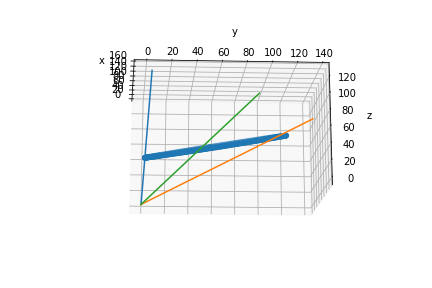

In [27]:
#尝试画出三个向量
#plt.switch_backend('Qt5Agg')
plt.switch_backend('nbAgg')
fig = plt.figure('new figure')
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(points_extent_draw[:,0], points_extent_draw[:,1], points_extent_draw[:,2])
scal = 200
ax.plot3D([va_zy[0]*scal, 0], [va_zy[1]*scal, 0], [va_zy[2]*scal, 0])
ax.plot3D([vb_zy[0]*scal, 0], [vb_zy[1]*scal, 0], [vb_zy[2]*scal, 0])
ax.plot3D([vc_zy[0]*scal, 0], [vc_zy[1]*scal, 0], [vc_zy[2]*scal, 0])
ax.scatter(60, 60, 60, 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

<IPython.core.display.Javascript object>


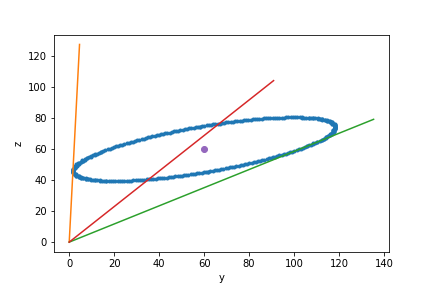

In [7]:
#尝试画出平面上的三个向量
#发现极值点在切线处
#plt.switch_backend('Qt5Agg')
plt.switch_backend('nbAgg')
plt.figure('123')
plt.plot(points_extent_draw[:,1], points_extent_draw[:,2], '.')
plt.plot([va_zy[1]*scal, 0], [va_zy[2]*scal, 0])
plt.plot([vb_zy[1]*scal, 0], [vb_zy[2]*scal, 0])
plt.plot([vc_zy[1]*scal, 0], [vc_zy[2]*scal, 0])
plt.xlabel('y')
plt.ylabel('z')
plt.plot(60, 60, 'o')
plt.show()

## 椭圆中心反变换不在圆环中心

In [7]:
print(center[0], center[1])

0.03088660888671875 0.02559041748046875


In [13]:
print(np.dot(K, np.array([60,60,60]))/60)

[ 0.03  0.03  1.  ]


## 一些前提和假设（未证明）

- 圆在相机中成像后，失去了深度信息(Z方向信息)，留下xy平面上的射影信息
- 圆在xy射影平面（焦平面）上是一个椭圆(相机光心，和空间中圆构成圆锥，圆锥和焦平面的截面是一个椭圆）
- 椭圆的中心(xe, ye)不对应圆中心(xc, yc, zc)，如图黄点和黑点


- 焦平面上的对应的极值点（红线，蓝线的端点）不对应空间圆的直径（这些极值点实际上是空间中圆在yz平面、xz平面上投影后，从原点发出的射线和投影图形的切点）
- 按照论文中的方法，需要准确知道圆中心的三维坐标


- 论文中使用同心圆射影的方式，估计圆中心坐标，以及位姿
- 是否只用单圆的方式，来估计圆的三维坐标，以及位姿


- 圆在空间中的位姿变换可以由两个自由度确定（

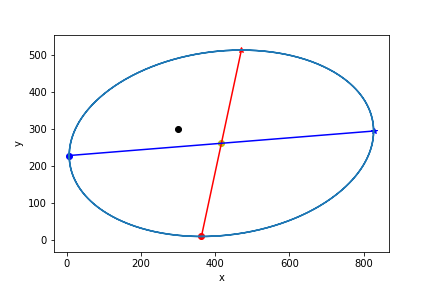

## 接下来工作

### 同心圆确定三维坐标

### 使用单圆确定三维坐标

**可行性分析**
- 光心和焦平面上的椭圆确定的（斜）圆锥体中，是否只存在一个正圆，半径为已知R？  
感觉可以唯一确定这样的一个正圆，特殊情况下，圆存在xy平面上，没有倾斜时，这时射影是一个正圆，此时确定的椎体中，只存在一个半径为R的正圆
- 圆位姿确定  
    - 位移矩阵T（圆心的坐标）
    - 旋转矩阵R，由下列二者构成
        - 旋转轴[u,v,w]
        - 旋转角度${theta}$  
假设标准形式下圆的两个轴和三维坐标系中的x,y轴
${\left(\array{}\right)}$
- 怎么确定圆的中心位置，和圆的位姿？

# 椭圆一般方程推导

## 方程推导

### 常用形式

${x = a*cos(\theta)}$  
${y = b*sin(\theta)}$  
${\frac{x^{2}}{a^{2}} + \frac{y^{2}}{b^{2}} = 1}$

In [74]:
gama1_zy1 = math.asin(oc_length_zy/r*sin(theta1_zy))
gama1_zy2 = pi - gama1_zy1
beta2_zy1 = math.asin(oc_length_zy/r*sin(theta2_zy))
beta2_zy2 = pi - beta2_zy1
print(gama1_zy1*180/pi, gama1_zy2*180/pi, beta2_zy1*180/pi, beta2_zy2*180/pi)

73.49943136559621 106.50056863440379 38.179761745655064 141.82023825434496


长短轴：
241.34474182128906 317.2539978027344


<IPython.core.display.Javascript object>


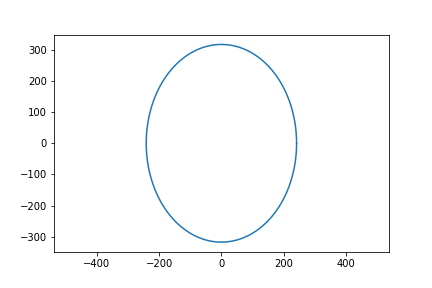

In [14]:
#%%matplotlib inline
plt.switch_backend('nbAgg')
theta = np.arange(0, 2*pi, 2*pi/1000)
a = axes[0]*10000/2
b = axes[1]*10000/2
print('长短轴：')
print(a, b)
x = a*np.cos(theta)
y = b*np.sin(theta)
plt.plot(x, y)
plt.axis('equal')
plt.show()

### 椭圆中心(xe, ye)

${x = a*cos(\theta) + xe}$  
${y = b*sin(\theta) + ye}$  
${\frac{(x-xe)^{2}}{a^{2}} + \frac{(y-ye)^{2}}{b^{2}} = 1}$

椭圆中心坐标：
308.8660888671875 255.9041748046875


<IPython.core.display.Javascript object>


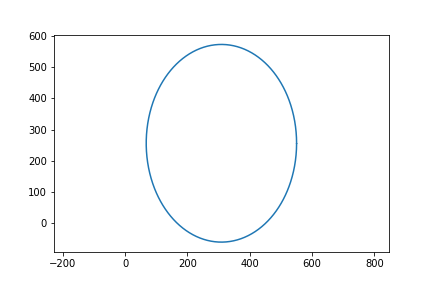

In [13]:
plt.switch_backend('nbAgg')
theta = np.arange(0, 2*pi, 2*pi/1000)
a = axes[0]*10000/2
b = axes[1]*10000/2
xe = center[0]*10000
ye = center[1]*10000
print('椭圆中心坐标：')
print(xe, ye)
x = a*np.cos(theta) + xe
y = b*np.sin(theta) + ye
plt.plot(x, y)
plt.axis('equal')
plt.show()

###  带倾斜角${\phi}$

(x,y)以原点为中心逆时针旋转角度${\phi}$得到${(x^{'}, y^{'})}$  
${x^{'} = cos(\phi)*x - sin(\phi)*y}$  
${y^{'} = sin(\phi)*x + cos(\phi)*y}$  

(x,y)以(xe, ye)为中心逆时针旋转角度${\phi}$得到${(x^{'}, y^{'})}$  
先移动到原点，然后再平移到(xe, ye)  
${x^{'} = cos(\phi)*(x-xe) - sin(\phi)*(y-ye) + xe}$  
${y^{'} = sin(\phi)*(x-xe) + cos(\phi)*(y-ye) + ye}$  

所以用${(x^{'}, y^{'})}$表示(x, y)为  
${x = cos(\phi)*(x^{'}-xe) + sin(\phi)*(y^{'}-ye) + xe}$  
${y = - sin(\phi)*(x^{'}-xe) + cos(\phi)*(y^{'}-ye) + ye}$  

最终，椭圆长短轴为(a, b)，椭圆中心为(xe, ye)，倾斜角度(逆时针旋转)${\phi}$，得到的椭圆方程为

${x^{'} = cos(\phi)*(x-xe) - sin(\phi)*(y-ye) + xe}$  
${y^{'} = sin(\phi)*(x-xe) + cos(\phi)*(y-ye) + ye}$ 

${\frac{(x-xe)^{2}}{a^{2}} + \frac{(y-ye)^{2}}{b^{2}} = 1}$  
${\frac{(cos(\phi)*(x^{'}-xe) + sin(\phi)*(y^{'}-ye))^{2}}{a^{2}} + \frac{(- sin(\phi)*(x^{'}-xe) + cos(\phi)*(y^{'}-ye))^{2}}{b^{2}} = 1}$  

参数方程为：  
${x = a*cos(\theta) + xe}$  
${y = b*sin(\theta) + ye}$  
${x^{'} = cos(\phi)*(x-xe) - sin(\phi)*(y-ye) + xe}$  
${y^{'} = sin(\phi)*(x-xe) + cos(\phi)*(y-ye) + ye}$  

${x^{'} = a*cos(\phi)*cos(\theta) - b*sin(\phi)*sin(\theta) + xe}$  
${y^{'} = a*sin(\phi)*cos(\theta) + b*cos(\phi)*sin(\theta) + ye}$

长短轴：
241.34474182128906 317.2539978027344
椭圆中心坐标：
308.8660888671875 255.9041748046875
倾斜角度：
70.23516845703125


<IPython.core.display.Javascript object>


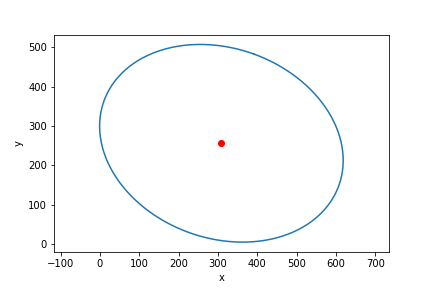

In [18]:
plt.switch_backend('nbAgg')
theta = np.arange(0, 2*pi, 2*pi/1000)
a = axes[0]*10000/2
b = axes[1]*10000/2
print('长短轴：')
print(a, b)
xe = center[0]*10000
ye = center[1]*10000
print('椭圆中心坐标：')
print(xe, ye)
#xe = center[0]*10000
#ye = center[1]*10000
phi = angle*pi/180
print('倾斜角度：')
print(phi*180/pi)
x = a*cos(phi)*np.cos(theta) - b*sin(phi)*np.sin(theta) + xe
y = a*sin(phi)*np.cos(theta) + b*cos(phi)*np.sin(theta) + ye
plt.plot(x, y)
plt.plot(xe, ye, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


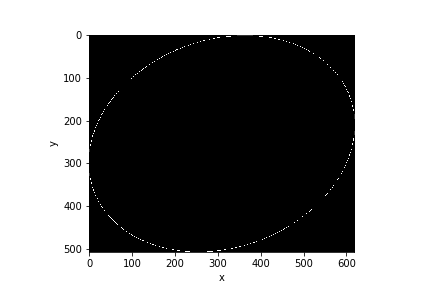

In [8]:
plt.imshow(img)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
#y轴方向不一样

## 椭圆的一般方程和标准方程的关系

### 椭圆标准方程

${\frac{(x-xe)^{2}}{a^{2}} + \frac{(y-ye)^{2}}{b^{2}} = 1}$  
${\frac{(cos(\phi)*(x^{'}-xe) + sin(\phi)*(y^{'}-ye))^{2}}{a^{2}} + \frac{(- sin(\phi)*(x^{'}-xe) + cos(\phi)*(y^{'}-ye))^{2}}{b^{2}} = 1}$  

### 椭圆参数方程

${x^{'} = a*cos(\phi)*cos(\theta) - b*sin(\phi)*sin(\theta) + xe}$  
${y^{'} = a*sin(\phi)*cos(\theta) + b*cos(\phi)*sin(\theta) + ye}$

### 椭圆一般方程

${a.x^{2} + b.y^{2} + c.x.y + d.x +e.y +f = 0}$

### 二者之间的关系

应该可以推导标准方程和一般方程之间的关系  
嫌麻烦-_-

## 由椭圆参数方程求极值

使用参数方程求导求极值即可，观察可知，下面两个方程是周期为${2\pi}$的对称函数  
- ${x^{'}}$取极值时  
${theta1^{*} = -\frac{b.sin(\phi)}{a*cos(\phi)}}$  
${theta2^{*} = -\frac{b.sin(\phi)}{a*cos(\phi)} + \pi}$  
- ${y^{'}}$取极值时  
${theta1^{*} = \frac{b.cos(\phi)}{a*sin(\phi)}}$  
${theta2^{*} = \frac{b.cos(\phi)}{a*sin(\phi)} + \pi}$ 

${x^{'} = a*cos(\phi)*cos(\theta) - b*sin(\phi)*sin(\theta) + xe}$  
${y^{'} = a*sin(\phi)*cos(\theta) + b*cos(\phi)*sin(\theta) + ye}$

<IPython.core.display.Javascript object>


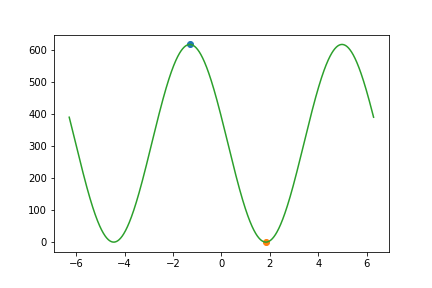

<IPython.core.display.Javascript object>


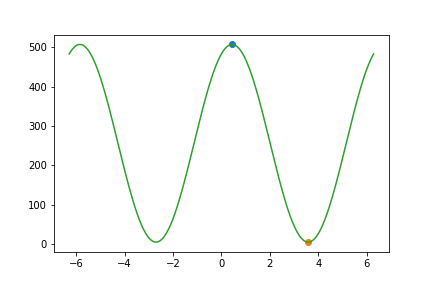

In [32]:
phi = angle*pi/180
a = axes[0]*10000/2
b = axes[1]*10000/2
xe = center[0]*10000
ye = center[1]*10000
def fx(theta):
    return a*cos(phi)*np.cos(theta) - b*sin(phi)*np.sin(theta) + xe
def fy(theta):
    return a*sin(phi)*np.cos(theta) + b*cos(phi)*np.sin(theta) + ye
theta = np.linspace(-2*pi,2*pi,num=1000)
theta_x = math.atan(-b*sin(phi)/(a*cos(phi)))
plt.figure()
plt.plot(theta_x, fx(theta_x), 'o')
plt.plot(theta_x+pi, fx(theta_x+pi), 'o')
plt.plot(theta, fx(theta))

theta_y = math.atan(b*cos(phi)/(a*sin(phi)))
plt.figure()
plt.plot(theta_y, fy(theta_y), 'o')
plt.plot(theta_y+pi, fy(theta_y+pi), 'o')
plt.plot(theta, fy(theta))

plt.show()